In [21]:
# Importing libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras

In [2]:
# Read data
ui_ratings = pd.read_csv('user_item_ratings.csv')

In [3]:
# Take a look at the data
ui_ratings

,user,item,x,observed,liked
0,1,1,1.546881,1,1
1,2,1,0.178921,1,0
2,3,1,-0.282547,1,1
3,4,1,-0.767299,0,0
4,5,1,-0.576404,1,0
...,...,...,...,...,...
2795,96,28,-0.616014,1,1
2796,97,28,0.020728,1,0
2797,98,28,-0.412832,1,0
2798,99,28,0.412128,1,0


In [4]:
# Get the dataset information
ui_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user      2800 non-null   int64  
 1   item      2800 non-null   int64  
 2   x         2800 non-null   float64
 3   observed  2800 non-null   int64  
 4   liked     2800 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 109.5 KB


In [5]:
# Number of users
print('The user item ratings dataset has', ui_ratings['user'].nunique(), 'unique users')

# Number of items
print('The user item ratings dataset has', ui_ratings['item'].nunique(), 'unique items')

The user item ratings dataset has 100 unique users
The user item ratings dataset has 28 unique items


Text(0.5, 1.0, 'User Liked Rating(x) Distribution')

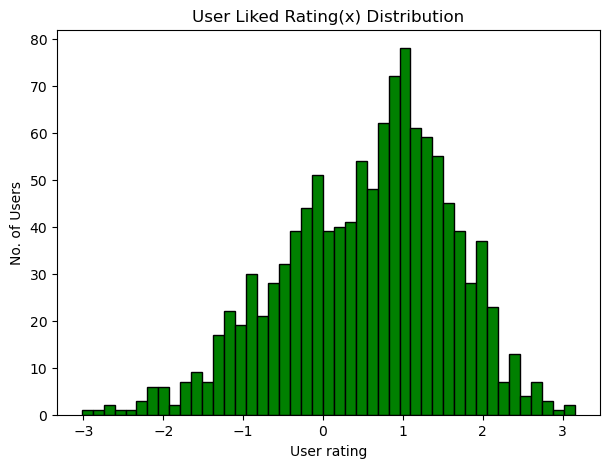

In [6]:
# Visualize User Liked Rating Distribution

from IPython.core.pylabtools import figsize

ui_ratings_liked  = ui_ratings.loc[ui_ratings['liked'] == 1]
ui_ratings_nliked = ui_ratings.loc[ui_ratings['liked'] == 0]

figsize(7, 5)
 
plt.hist(ui_ratings_liked['x'], color='green', edgecolor='black', bins=int(45/1))
 
plt.xlabel('User rating')
plt.ylabel('No. of Users')
plt.title('User Liked Rating(x) Distribution')

Text(0.5, 1.0, 'User Not-Liked Rating(x) Distribution')

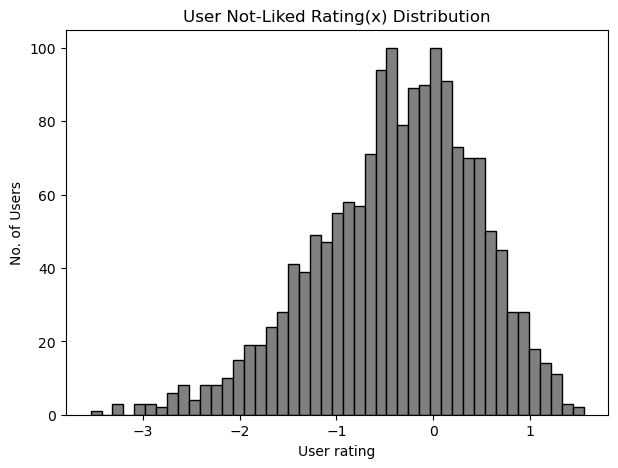

In [7]:
figsize(7, 5)
 
plt.hist(ui_ratings_nliked['x'], color='grey', edgecolor='black', bins=int(45/1))
 
plt.xlabel('User rating')
plt.ylabel('No. of Users')
plt.title('User Not-Liked Rating(x) Distribution')

Text(0.5, 1.0, 'Average Liked Rating(x) Distribution')

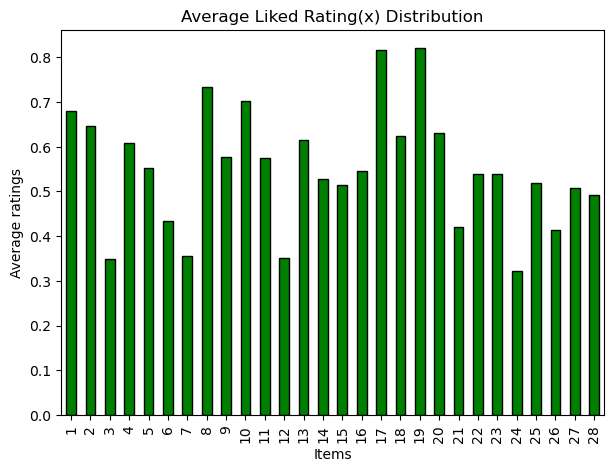

In [8]:
ui_ratings_liked.groupby('item').mean()['x'].plot.bar(color='green', edgecolor='black')
plt.xlabel('Items')
plt.ylabel('Average ratings')
plt.title('Average Liked Rating(x) Distribution')

Text(0.5, 1.0, 'Average Not-Liked Rating(x) Distribution')

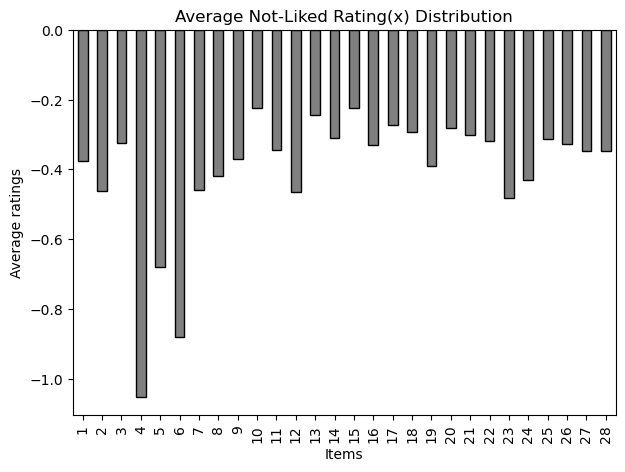

In [9]:
ui_ratings_nliked.groupby('item').mean()['x'].plot.bar(color='grey', edgecolor='black')
plt.xlabel('Items')
plt.ylabel('Average ratings')
plt.title('Average Not-Liked Rating(x) Distribution')

### Encoding users and items

In [10]:
user_enc = LabelEncoder()
ui_ratings['user'] = user_enc.fit_transform(ui_ratings['user'].values)
n_users = ui_ratings['user'].nunique()

item_enc = LabelEncoder()
ui_ratings['item'] = item_enc.fit_transform(ui_ratings['item'].values)
n_items = ui_ratings['item'].nunique()

In [11]:
ui_ratings

,user,item,x,observed,liked
0,0,0,1.546881,1,1
1,1,0,0.178921,1,0
2,2,0,-0.282547,1,1
3,3,0,-0.767299,0,0
4,4,0,-0.576404,1,0
...,...,...,...,...,...
2795,95,27,-0.616014,1,1
2796,96,27,0.020728,1,0
2797,97,27,-0.412832,1,0
2798,98,27,0.412128,1,0


In [12]:
ui_ratings['liked'] = ui_ratings['liked'].values.astype(np.float32)
min_rating = min(ui_ratings['liked'])
max_rating = max(ui_ratings['liked'])
n_users, n_items, min_rating, max_rating

(100, 28, 0.0, 1.0)

### Splitting the data into training and testing using observed variable

In [13]:
X = ui_ratings
y = X.pop('liked')

gs = GroupShuffleSplit(n_splits=2, random_state=42)

train_ix, test_ix = next(gs.split(X, y, groups=X.observed))

X_test = X.loc[train_ix].values
y_test = y.loc[train_ix]

X_train = X.loc[test_ix].values
y_train = y.loc[test_ix]

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2515, 4), (285, 4), (2515,), (285,))

### Defining number of factors which are to be considered by the Embedding layer

In [15]:
n_factors = 150

In [16]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

### Building a  Deep Neural Network

In [17]:
## Initializing input layers for users and items
user = tf.keras.layers.Input(shape = (1,))
u = tf.keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal')(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

item = tf.keras.layers.Input(shape = (1,))
i = tf.keras.layers.Embedding(n_items, n_factors, embeddings_initializer = 'he_normal')(item)
i = tf.keras.layers.Reshape((n_factors,))(i)

## concatenate both user and item input layers
x = tf.keras.layers.Concatenate()([u,i])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding Dense layer
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='sigmoid')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(10, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='sigmoid')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion
x = tf.keras.layers.Dense(1)(x)
x = tf.keras.layers.Activation(activation='sigmoid')(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,item], outputs=x)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 150)       15000       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 150)       4200        ['input_2[0][0]']                
                                                                                              

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

model_train = model.fit(x = X_train_array, y = y_train, batch_size = 128, epochs = 70, verbose = 1,
                                        validation_data = (X_test_array, y_test), shuffle = True, callbacks = [reduce_lr])

Epoch 1/70
20/20 [==============================] - 4s 43ms/step - loss: 0.6945 - accuracy: 0.5078 - val_loss: 0.6840 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 2/70
20/20 [==============================] - 0s 12ms/step - loss: 0.6810 - accuracy: 0.5865 - val_loss: 0.6805 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 3/70
20/20 [==============================] - 0s 12ms/step - loss: 0.6771 - accuracy: 0.5853 - val_loss: 0.6810 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 4/70
20/20 [==============================] - 0s 12ms/step - loss: 0.6757 - accuracy: 0.5841 - val_loss: 0.6813 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 5/70
20/20 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.5857
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
20/20 [==============================] - 0s 13ms/step - loss: 0.6736 - accuracy: 0.5857 - val_loss: 0.6820 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 6/70
20/20 [==============================] - 0s 12ms/step - loss

Epoch 48/70
20/20 [==============================] - 0s 13ms/step - loss: 0.4458 - accuracy: 0.8390 - val_loss: 0.5091 - val_accuracy: 0.8175 - lr: 2.3730e-04
Epoch 49/70
20/20 [==============================] - 0s 11ms/step - loss: 0.4368 - accuracy: 0.8473 - val_loss: 0.5039 - val_accuracy: 0.8211 - lr: 2.3730e-04
Epoch 50/70
20/20 [==============================] - 0s 12ms/step - loss: 0.4348 - accuracy: 0.8433 - val_loss: 0.4984 - val_accuracy: 0.8246 - lr: 2.3730e-04
Epoch 51/70
20/20 [==============================] - 0s 13ms/step - loss: 0.4271 - accuracy: 0.8449 - val_loss: 0.4939 - val_accuracy: 0.8281 - lr: 2.3730e-04
Epoch 52/70
20/20 [==============================] - 0s 13ms/step - loss: 0.4201 - accuracy: 0.8485 - val_loss: 0.4902 - val_accuracy: 0.8246 - lr: 2.3730e-04
Epoch 53/70
20/20 [==============================] - 0s 12ms/step - loss: 0.4165 - accuracy: 0.8525 - val_loss: 0.4860 - val_accuracy: 0.8246 - lr: 2.3730e-04
Epoch 54/70
20/20 [===========================

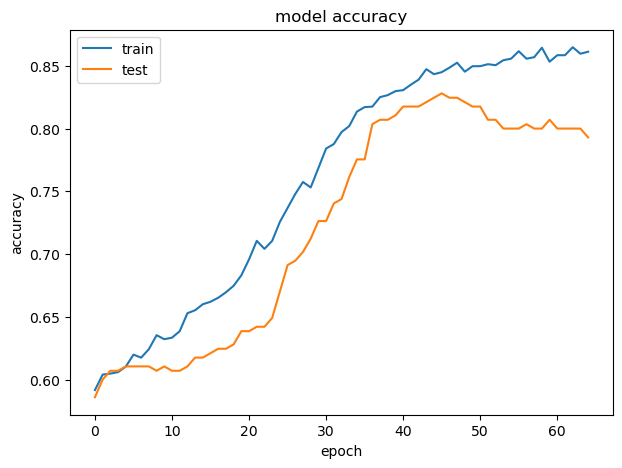

In [20]:
plt.plot(model_train.history["accuracy"][5:])
plt.plot(model_train.history["val_accuracy"][5:])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

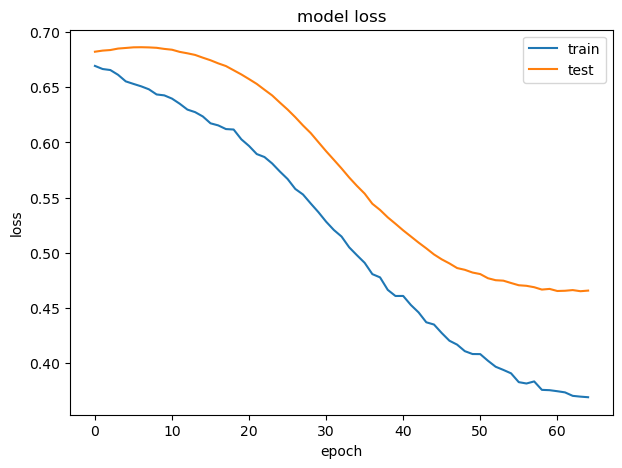

In [21]:
plt.plot(model_train.history["loss"][5:])
plt.plot(model_train.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

### Predicting test items for test data

In [62]:
model_input = X_test_array
len(model_input), len(model_input[0])

(2, 285)

In [63]:
predicted_ratings = pd.DataFrame(model.predict(model_input), columns=['liked_pred'])

9/9 [==============================] - 0s 5ms/step


In [64]:
predicted_ratings

,liked_pred
0,0.141153
1,0.864049
2,0.377805
3,0.093537
4,0.076579
...,...
280,0.127880
281,0.084410
282,0.182695
283,0.183300


In [65]:
user_item = pd.DataFrame({'user': model_input[0]+1, 'item': model_input[1]+1, 'liked_actual': y_test.tolist()})
ui_test_pred = pd.concat([user_item, predicted_ratings], axis=1).applymap(lambda x: int(x + 0.5))

ui_test_pred = pd.concat([ui_test_pred, round(predicted_ratings,2)], axis=1)
ui_test_pred.columns.values[4] = 'liked_pred_prob'
ui_test_pred

,user,item,liked_actual,liked_pred,liked_pred_prob
0,4,1,0,0,0.14
1,7,1,1,1,0.86
2,18,1,1,0,0.38
3,21,1,0,0,0.09
4,61,1,0,0,0.08
...,...,...,...,...,...
280,18,28,0,0,0.13
281,26,28,0,0,0.08
282,29,28,0,0,0.18
283,77,28,0,0,0.18


In [61]:
ui_test_pred.to_csv("user_item_test_pred.csv")

### Ploting confusion matrix

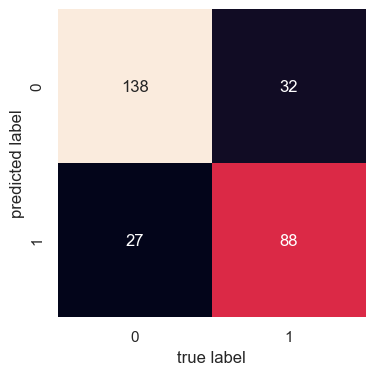

In [25]:
# Ploting confusion matrix with 'seaborn' module

actual = list(ui_test_pred.loc[:,'liked_actual'])
predicted = list(ui_test_pred.loc[:,'liked_pred'])
test_labels = np.unique(list(ui_test_pred.loc[:,'liked_pred']))

mat = confusion_matrix(actual, predicted)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=test_labels,
            yticklabels=test_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

### Printing classification report

In [26]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       165
           1       0.77      0.73      0.75       120

    accuracy                           0.79       285
   macro avg       0.79      0.78      0.79       285
weighted avg       0.79      0.79      0.79       285

